# Cas13Hunter: CRISPR-Cas13 Guide RNA Design

## 0. Overview

This notebook designs CRISPR-Cas13 guide RNAs targeting conserved regions of the viral genome. Guide RNAs are short RNA sequences that direct the Cas13 protein to specific RNA regions for cleavage. Conserved regions, identified in `02_alignment_analysis.ipynb`, are used as the basis for guide RNA design. The guide RNAs design step include:

1. __Load conserved positions and aligned sequences.__
2. __Extract sequences around conserved positions.__
3. __Design and evaluate guide RNAs.__
4. __Check for off-target effects.__
5. __Save designed guides for downstream evaluation.__
6. __Visualise guide RNA characteristics.__


## 1. Import Libraries

In this step, we import the required Python libraries for designing CRISPR-Cas13 guide RNAs:

- **`os`**: For file path management and ensuring the existence of required files.
- **`numpy`**: To load and process the conserved positions stored in `.npy` format.
- **`Bio` (from Biopython)**: For handling biological sequence data, such as aligned sequences in FASTA format.
- **`matplotlib.pyplot`**: For creating visualisations, such as GC content distribution of guide RNAs.
- **`pandas`**: For managing and analyzing guide RNA data in a structured tabular format.

These libraries are essential for working with conserved regions, processing sequence data, evaluating guide RNAs, and visualszing results.


In [3]:
import os
import numpy as np
from Bio import SeqIO
import matplotlib.pyplot as plt
import pandas as pd


## 2. Load Conserved Positions and Aligned Sequences

In this step, we load the conserved positions and aligned sequences from the previous steps of the pipeline.

__Steps:__
1. **Load Conserved Positions**:
   - Conserved positions were identified in the `02_alignment_analysis.ipynb` notebook and saved as a `.npy` file.
   - These positions represent genome locations with high conservation across all aligned sequences.

2. **Load Aligned Sequences**:
   - The aligned sequences, generated using MAFFT in `02_alignment_analysis.ipynb`, are loaded from the saved FASTA file.
   - Each sequence in the alignment corresponds to a viral genome, with gaps (`-`) introduced to optimize alignment.

__Importance:__
- Conserved positions serve as the basis for guide RNA design, ensuring the guides target critical and consistent regions of the genome.
- The aligned sequences allow us to extract sequences surrounding the conserved positions for further evaluation.

__Output:__
- A list of conserved positions (`conserved_positions`).
- A collection of aligned sequences (`alignment`).


In [5]:
# Define file paths
PROCESSED_DATA_DIR = "../data/processed/"
aligned_file = os.path.join(PROCESSED_DATA_DIR, "aligned_sequences.fasta")
conserved_file = os.path.join(PROCESSED_DATA_DIR, "conserved_regions.npy")

# Load conserved positions
if not os.path.exists(conserved_file):
    raise FileNotFoundError(f"Conserved regions file not found: {conserved_file}")
conserved_positions = np.load(conserved_file)
print(f"Loaded {len(conserved_positions)} conserved positions.")

# Load aligned sequences
if not os.path.exists(aligned_file):
    raise FileNotFoundError(f"Aligned file not found: {aligned_file}")
alignment = list(SeqIO.parse(aligned_file, "fasta"))
print(f"Loaded {len(alignment)} aligned sequences.")


Loaded 35119 conserved positions.
Loaded 453 aligned sequences.


## 3. Extract Conserved Sequences

In this step, we extract sequences surrounding the conserved positions identified earlier. These extracted sequences are candidates for CRISPR-Cas13 guide RNA design.

__Steps:__
1. **Define a Window**:
   - A fixed window size (e.g., 30 bases) is defined around each conserved position to extract a small region of the genome.
   - This ensures the guide RNAs target not just the conserved position but its surrounding context.

2. **Handle Gaps**:
   - Gaps (`-`) introduced during the alignment are removed from the extracted sequences to ensure accurate guide design.

3. **Store Guide Candidates**:
   - Each extracted sequence is stored as a potential guide candidate, along with metadata such as:
     - Conserved position.
     - Sequence ID (to trace it back to the original genome).
     - Extracted guide sequence.

__Importance:__
- **Guide RNA Targeting**: Extracted sequences around conserved positions are ideal candidates for CRISPR-Cas13 targeting.
- **Context Preservation**: Including bases around conserved positions ensures guides are specific and robust.

__Output:__
- A list of guide candidates, each containing:
  - The conserved position.
  - The sequence ID.
  - The extracted guide sequence.


In [6]:
# Extract sequences surrounding conserved positions
WINDOW_SIZE = 30  # Number of bases around conserved positions
guide_candidates = []

for pos in conserved_positions:
    for record in alignment:
        start = max(0, pos - WINDOW_SIZE // 2)
        end = min(len(record.seq), pos + WINDOW_SIZE // 2)
        guide_seq = str(record.seq[start:end]).replace("-", "")  # Remove gaps
        if len(guide_seq) == WINDOW_SIZE:
            guide_candidates.append({
                "conserved_pos": pos,
                "sequence_id": record.id,
                "guide_sequence": guide_seq
            })

print(f"Extracted {len(guide_candidates)} guide candidates.")
if guide_candidates:
    print("Example guide candidate:", guide_candidates[0])


Extracted 10760671 guide candidates.


## 4. Evaluate Guide RNA Candidates

In this step, we evaluate the extracted guide RNA candidates to ensure they meet criteria for effective and specific targeting.

__Steps:__
1. **Guide Length**:
   - Only sequences of a specific length (e.g., 22 bases) are considered valid guide RNAs.
   - This length is typically chosen based on Cas13's functional requirements.

2. **GC Content**:
   - The GC content of each guide sequence is calculated as:
     $\text{GC Content (\%)} = \frac{\text{Count of G + Count of C}}{\text{Total Bases}} \times 100$
   - Guides with GC content within an acceptable range (e.g., 30–70%) are retained to ensure proper hybridisation and stability.

3. **Filter Invalid Guides**:
   - Sequences that are too short, too long, or have GC content outside the acceptable range are discarded.

4. **Store Metadata**:
   - Valid guides are stored with additional metadata:
     - Conserved position.
     - Sequence ID.
     - Guide sequence.
     - GC content.

__Importance:__
- **Targeting Efficiency**: Proper length and GC content ensure the guide RNA binds effectively to the target RNA.
- **Specificity**: Filtering guides based on these criteria minimises the chances of off-target effects.

__Output:__
- A structured dataset (e.g., a Pandas `DataFrame`) of valid guide RNAs, ready for visualisation and downstream analysis.


In [13]:
# Evaluate GC content and length for each guide
def calculate_gc_content(seq):
    """
    Calculate the GC content of a nucleotide sequence.
    Args:
        seq (str): Nucleotide sequence.
    Returns:
        float: GC content as a percentage.
    """
    seq = seq.upper()  # Convert to uppercase to handle lowercase bases
    return (seq.count("G") + seq.count("C")) / len(seq) * 100 if seq else 0

# Filter and evaluate guides
GUIDE_LENGTH = 22  # Typical guide RNA length for Cas13
valid_guides = []

# Debugging info: Check guide candidate lengths and case
print(f"Total guide candidates: {len(guide_candidates)}")
if guide_candidates:
    print(f"Example guide candidate: {guide_candidates[0]}")

for guide in guide_candidates:
    guide_seq = guide["guide_sequence"][:GUIDE_LENGTH].upper()  # Convert to uppercase and slice
    if len(guide_seq) == GUIDE_LENGTH:  # Ensure guide is of sufficient length
        gc_content = calculate_gc_content(guide_seq)
        if 40 <= gc_content <= 70:  # Adjust GC content range
            valid_guides.append({
                "conserved_pos": guide["conserved_pos"],
                "sequence_id": guide["sequence_id"],
                "guide_sequence": guide_seq,
                "gc_content": gc_content
            })

# Convert to a DataFrame for easier analysis
valid_guides_df = pd.DataFrame(valid_guides)
print(f"Generated {len(valid_guides)} valid guide RNAs.")

# Debugging info: Check GC content distribution
if not valid_guides_df.empty:
    print(valid_guides_df.head())
else:
    print("No valid guide RNAs found. Check candidate extraction and GC content thresholds.")


Total guide candidates: 10760671
Example guide candidate: {'conserved_pos': 54, 'sequence_id': 'OY087957.1', 'guide_sequence': 'ctttygatctcttgtagatctgttctctaa'}
Generated 5047947 valid guide RNAs.
   conserved_pos sequence_id          guide_sequence  gc_content
0            120  OR903717.1  TGTTCTCTAAACGAACCTGTTC   40.909091
1            121  OR903717.1  GTTCTCTAAACGAACCTGTTCT   40.909091
2            122  OR903717.1  TTCTCTAAACGAACCTGTTCTC   40.909091
3            123  OR903717.1  TCTCTAAACGAACCTGTTCTCT   40.909091
4            124  OR903717.1  CTCTAAACGAACCTGTTCTCTA   40.909091


In [17]:
valid_guides_df

,conserved_pos,sequence_id,guide_sequence,gc_content
0,120,OR903717.1,TGTTCTCTAAACGAACCTGTTC,40.909091
1,121,OR903717.1,GTTCTCTAAACGAACCTGTTCT,40.909091
2,122,OR903717.1,TTCTCTAAACGAACCTGTTCTC,40.909091
3,123,OR903717.1,TCTCTAAACGAACCTGTTCTCT,40.909091
4,124,OR903717.1,CTCTAAACGAACCTGTTCTCTA,40.909091
...,...,...,...,...
5047942,35343,PP219430.1,ATGCTAGGGAGAGCTGCCTATA,50.000000
5047943,35343,OV096826.1,ATGCTAGGGATAGCTGCCTATA,45.454545
5047944,35343,OL834639.1,ATGCTAGGGAGAGCTGCCTATA,50.000000
5047945,35343,OL393566.1,ATGCTAGGGAGAGCTGCCTATA,50.000000


## 5. Visualise Guide Characteristics

In this step, we create visualisations to analyse the characteristics of the designed CRISPR-Cas13 guide RNAs. This helps us understand the distribution of important properties, such as GC content.

__Steps:__
1. **Plot GC Content Distribution**:
   - A histogram is created to show the distribution of GC content among the valid guide RNAs.
   - The x-axis represents GC content percentages, and the y-axis represents the number of guides in each range.

2. **Interpretation**:
   - Guides with GC content in the acceptable range (e.g., 30–70%) are likely to bind effectively to the target RNA.
   - The plot highlights whether the designed guides are evenly distributed across the acceptable range or concentrated in specific regions.

__Importance:__
- **Guide RNA Design**:
   - Analysing GC content helps ensure the guides are suitable for robust hybridisation.
- **Data Quality**:
   - Visualising guide characteristics provides insights into the diversity and quality of the designed guides.

__Output:__
- A histogram showing the GC content distribution of valid guide RNAs.


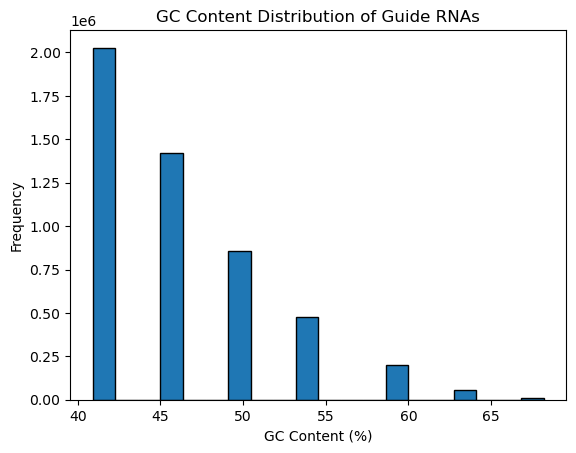

In [14]:
# Plot GC content distribution
plt.hist(valid_guides_df["gc_content"], bins=20, edgecolor="black")
plt.title("GC Content Distribution of Guide RNAs")
plt.xlabel("GC Content (%)")
plt.ylabel("Frequency")
plt.show()

## 6. Save Designed Guides

In this step, we save the valid guide RNAs and their associated metadata to a file for future use and downstream analyses.

__Steps:__
1. **Organise Data**:
   - The valid guide RNAs, along with their metadata (e.g., conserved position, sequence ID, GC content), are stored in a structured format (e.g., a Pandas `DataFrame`).

2. **Save to CSV**:
   - The DataFrame is saved as a `.csv` file, a widely used format that can be easily imported into other tools or scripts for further analysis.

__Importance:__
- **Reproducibility**:
   - Storing the designed guides ensures results can be reproduced and shared without rerunning the entire pipeline.
- **Integration**:
   - The saved file can be directly used in downstream tasks, such as off-target analysis or experimental validation.

__Output:__
- A CSV file (`designed_guides.csv`) containing:
  - Conserved positions targeted by the guide RNAs.
  - Sequence IDs for traceability.
  - Guide RNA sequences and their GC content.


In [16]:
# Save guides to a CSV file
guides_file = os.path.join(PROCESSED_DATA_DIR, "designed_guides.csv")
valid_guides_df.to_csv(guides_file, index=False)
print(f"Designed guides saved to: {guides_file}")


Designed guides saved to: ../data/processed/designed_guides.csv
